In [1]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.4.1'

In [2]:
# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
project_path = '/content/drive/My Drive/AIML/Capstone project/'

In [5]:
import pandas as pd
import numpy as np
import os

In [6]:
class_names_data = pd.read_csv(project_path+"names.csv", header=None, names=["class_name"])
train_annotate = pd.read_csv(project_path+"anno_train.csv", header=None, names=["image_file","x0","y0","x1","y1","class"])
test_annotate = pd.read_csv(project_path+"anno_test.csv", header=None, names=["image_file","x0","y0","x1","y1","class"])

In [7]:
class_names_data.head(10)

,class_name
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012
5,Acura Integra Type R 2001
6,Acura ZDX Hatchback 2012
7,Aston Martin V8 Vantage Convertible 2012
8,Aston Martin V8 Vantage Coupe 2012
9,Aston Martin Virage Convertible 2012


In [8]:
train_annotate.head(10)

,image_file,x0,y0,x1,y1,class
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106
5,00006.jpg,259,289,515,416,123
6,00007.jpg,88,80,541,397,89
7,00008.jpg,73,79,591,410,96
8,00009.jpg,20,126,1269,771,167
9,00010.jpg,21,110,623,367,58


In [9]:
test_annotate.head(10)

,image_file,x0,y0,x1,y1,class
0,00001.jpg,30,52,246,147,181
1,00002.jpg,100,19,576,203,103
2,00003.jpg,51,105,968,659,145
3,00004.jpg,67,84,581,407,187
4,00005.jpg,140,151,593,339,185
5,00006.jpg,20,77,420,301,78
6,00007.jpg,249,166,2324,1459,118
7,00008.jpg,119,215,1153,719,165
8,00009.jpg,1,7,275,183,32
9,00010.jpg,28,55,241,177,60


In [21]:
class_names_data['class_name'][196%195]

'Acura RL Sedan 2012'

In [22]:
train_annotate['class_name'] = train_annotate.apply(lambda x: class_names_data['class_name'][x['class']%len(class_names_data['class_name'])], axis=1)

In [23]:
train_annotate

,image_file,x0,y0,x1,y1,class,class_name
0,00001.jpg,39,116,569,375,14,Audi R8 Coupe 2012
1,00002.jpg,36,116,868,587,3,Acura TL Type-S 2008
2,00003.jpg,85,109,601,381,91,Dodge Magnum Wagon 2008
3,00004.jpg,621,393,1484,1096,134,Hyundai Elantra Sedan 2007
4,00005.jpg,14,36,133,99,106,Ford Mustang Convertible 2007
...,...,...,...,...,...,...,...
8139,08140.jpg,3,44,423,336,78,Chrysler 300 SRT-8 2010
8140,08141.jpg,138,150,706,523,196,AM General Hummer SUV 2000
8141,08142.jpg,26,246,660,449,163,Mercedes-Benz E-Class Sedan 2012
8142,08143.jpg,78,526,1489,908,112,Ford F-150 Regular Cab 2012


In [28]:
train_image_path = project_path+"car_data/car_data/train"

In [32]:
train_image_dir = os.listdir(train_image_path)
train_image_list=[]
for i in train_image_dir:
  for f in os.listdir(os.path.join(train_image_path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
              train_image_list.append("{}/{}".format(i,f))

In [33]:
train_image_list

['BMW X5 SUV 2007/07311.jpg',
 'BMW X5 SUV 2007/07308.jpg',
 'BMW X5 SUV 2007/01966.jpg',
 'BMW X5 SUV 2007/03534.jpg',
 'BMW X5 SUV 2007/00366.jpg',
 'BMW X5 SUV 2007/05463.jpg',
 'BMW X5 SUV 2007/04736.jpg',
 'BMW X5 SUV 2007/06252.jpg',
 'BMW X5 SUV 2007/06662.jpg',
 'BMW X5 SUV 2007/06204.jpg',
 'BMW X5 SUV 2007/05132.jpg',
 'BMW X5 SUV 2007/08058.jpg',
 'BMW X5 SUV 2007/06559.jpg',
 'BMW X5 SUV 2007/02018.jpg',
 'BMW X5 SUV 2007/02081.jpg',
 'BMW X5 SUV 2007/06676.jpg',
 'BMW X5 SUV 2007/06605.jpg',
 'BMW X5 SUV 2007/07134.jpg',
 'BMW X5 SUV 2007/07592.jpg',
 'BMW X5 SUV 2007/04719.jpg',
 'BMW X5 SUV 2007/03935.jpg',
 'BMW X5 SUV 2007/04060.jpg',
 'BMW X5 SUV 2007/03180.jpg',
 'BMW X5 SUV 2007/06620.jpg',
 'BMW X5 SUV 2007/03617.jpg',
 'BMW X5 SUV 2007/02221.jpg',
 'BMW X5 SUV 2007/04171.jpg',
 'BMW X5 SUV 2007/07389.jpg',
 'BMW X5 SUV 2007/01061.jpg',
 'BMW X5 SUV 2007/01613.jpg',
 'BMW X5 SUV 2007/01656.jpg',
 'BMW X5 SUV 2007/00650.jpg',
 'BMW X5 SUV 2007/07263.jpg',
 'BMW X5 S

In [36]:
import cv2
img = cv2.imread(train_image_path+"/"+train_image_list[2],1)

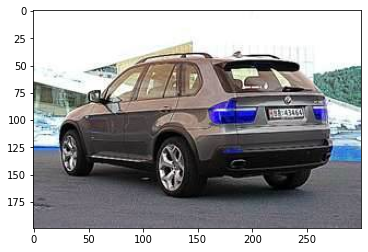

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(img)
plt.show()

In [38]:
train_image_list[2]

'BMW X5 SUV 2007/01966.jpg'

In [82]:
df = train_annotate[train_annotate["image_file"] == "01966.jpg"]
df.reset_index(drop=True, inplace=True)

In [83]:
df

,image_file,x0,y0,x1,y1,class,class_name
0,01966.jpg,24,37,276,169,32,BMW X6 SUV 2012


In [84]:
df.x0.values[0]

24

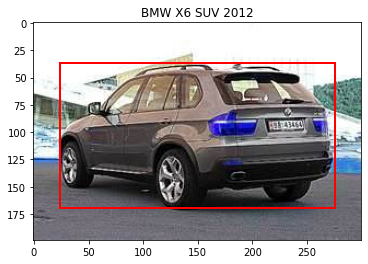

In [85]:
x0=df.x0.values[0]
x1=df.x1.values[0]
y0=df.y0.values[0]
y1=df.y1.values[0]


import matplotlib.patches as patches

fig, ax = plt.subplots(1)
ax.imshow(img)
rect = patches.Rectangle((x0,y0), (x1-x0),(y1-y0),
                         linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.title(df.class_name.values[0])
plt.show()